In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
font_prop = fm.FontProperties(fname=font_path)

In [5]:
'''
data preprocessing
'''
data_path = "/home/elu/VPP/DLinear_for_price_prediction/data/"
data_path_2024 = data_path + "2024/"
data_path_2025 = data_path + "2025/"

elec_price_df = pd.read_csv(data_path_2024 + "内蒙2024电价数据_24点_cleaned.csv", sep="\t")
elec_out_price_df = pd.read_csv(data_path_2024 + "内蒙2024东送计划_96点_cleaned.csv", sep="\t")
non_martket_elec_gen_df = pd.read_csv(data_path_2024 + "内蒙2024非市场化出力_96点_cleaned.csv", sep="\t")
ele_load_df = pd.read_csv(data_path_2024 + "内蒙2024负荷数据_96点_cleaned.csv", sep="\t")
new_energy_elec_gen_df = pd.read_csv(data_path_2024 + "内蒙2024新能源出力数据_96点_cleaned.csv", sep="\t")

df_15 = [elec_out_price_df, non_martket_elec_gen_df, ele_load_df, new_energy_elec_gen_df]

for i in range(len(df_15)):
    df = df_15[i]
    df = df.sort_values('datetime')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df.resample('H', closed='right', label='right').mean()
    df_15[i] = df
    # print(df.head())

elec_price_df['datetime'] = pd.to_datetime(elec_price_df['datetime'])
elec_price_df.set_index('datetime', inplace=True)

merged_df = pd.concat([elec_price_df] + df_15, axis=1)

print(merged_df.columns)

Index(['全网统一出清电价', '呼包东统一出清电价', '呼包西统一出清电价', '日前预出清电能价格', '东送计划预测', '东送计划实测',
       '非市场出力计划', '非市场出力计划实测', '统调负荷预测', '统调负荷实测', '新能源出力预测', '新能源出力实测',
       '风电出力预测', '风电出力实测', '光伏出力预测', '光伏出力实测'],
      dtype='object')


In [ ]:
bidding_space_df = merged_df.drop(columns=[])

In [ ]:


target_columns = ['呼包东统一出清电价', '呼包西统一出清电价']

scaler = StandardScaler()
data_scaled = scaler.fit_transform(merged_df.values)
data_array = data_scaled

print(f"\nData shape after normalization：{data_array.shape}")

'''
build DLinear model
'''
# 2. 构造滑动窗口数据

def create_sliding_windows(data, input_length, output_length, target_indices):
    """
    构造滑动窗口数据
    :param data: numpy 数组，形状 (T, num_features)
    :param input_length: 输入序列长度（例如24个点代表1天）
    :param output_length: 输出序列长度（预测下一天的24个点）
    :param target_indices: 目标特征在数据中的索引列表
    :return: X, Y，分别为输入和目标序列
    """
    X, Y = [], []
    total_length = data.shape[0]
    for i in range(total_length - input_length - output_length + 1):
        # 取出输入序列：过去 input_length 个时间点的所有特征
        x_i = data[i : i + input_length, :]
        # 取出输出序列：接下来 output_length 个时间点的目标特征
        y_i = data[i + input_length : i + input_length + output_length, :][:, target_indices]
        X.append(x_i)
        Y.append(y_i)
    return np.array(X), np.array(Y)

# 对于60分钟一个点的情况，一天有24个点
input_length = 24    # 输入序列长度：1天数据
output_length = 24   # 输出序列长度：预测下一天

# 获取目标特征的索引
features = merged_df.columns.tolist()
target_indices = [features.index(col) for col in target_columns]

# 构造滑动窗口数据
X, Y = create_sliding_windows(data_array, input_length, output_length, target_indices)
print(f"\n构造后的样本数量：{X.shape[0]}")
print(f"每个输入样本的形状：{X.shape[1:]}")   # (input_length, num_features)
print(f"每个目标样本的形状：{Y.shape[1:]}")   # (output_length, len(target_columns))

# 3. 构造 PyTorch Dataset 和 DataLoader 🚀

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        """
        :param X: numpy 数组，形状 (num_samples, input_length, num_features)
        :param Y: numpy 数组，形状 (num_samples, output_length, num_target_features)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# 划分训练集和验证集（例如 80% 训练，20% 验证）
split_idx = int(0.8 * X.shape[0])
X_train, Y_train = X[:split_idx], Y[:split_idx]
X_val, Y_val = X[split_idx:], Y[split_idx:]

train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset = TimeSeriesDataset(X_val, Y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 4. 构建 DLinear 模型

class DLinear(nn.Module):
    def __init__(self, input_length, output_length, num_features, target_feature_num):
        """
        :param input_length: 输入序列的时间步数（24个点）
        :param output_length: 输出序列的时间步数（24个点）
        :param num_features: 输入特征数量
        :param target_feature_num: 目标特征数量（例如2个区域的电价）
        """
        super(DLinear, self).__init__()
        # 为每个输入特征创建一个独立的线性层
        self.linear_layers = nn.ModuleList([
            nn.Linear(input_length, output_length) for _ in range(num_features)
        ])
        self.num_features = num_features
        self.target_feature_num = target_feature_num
        
    def forward(self, x):
        """
        :param x: 输入张量，形状 (batch_size, input_length, num_features)
        :return: 预测结果，形状 (batch_size, output_length, target_feature_num)
        """
        out_list = []
        # 对每个特征独立进行预测
        for i, layer in enumerate(self.linear_layers):
            # 取出第 i 个特征，形状：(batch_size, input_length)
            xi = x[:, :, i]
            # 线性预测得到：(batch_size, output_length)
            yi = layer(xi)
            out_list.append(yi.unsqueeze(-1))  # 变为 (batch_size, output_length, 1)
        # 拼接所有特征的预测结果，形状：(batch_size, output_length, num_features)
        out = torch.cat(out_list, dim=-1)
        # 选择目标特征（这里假设目标特征在所有特征中位于前面）
        prediction = out[:, :, :self.target_feature_num]
        return prediction

# 模型参数
num_features = len(features)           # 输入所有特征的数量
target_feature_num = len(target_columns) # 预测目标的数量（2个区域）

model = DLinear(input_length=input_length, 
                output_length=output_length, 
                num_features=num_features, 
                target_feature_num=target_feature_num)

print("\nDLinear 模型结构：")
print(model)

# 5. 模型训练 💪

# 定义损失函数（均方误差）和优化器（Adam）
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20  # 根据实际情况调整

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        # 反向传播与优化
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * batch_X.size(0)
    
    epoch_train_loss /= len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # 验证阶段
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            epoch_val_loss += loss.item() * batch_X.size(0)
    epoch_val_loss /= len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.6f} - Val Loss: {epoch_val_loss:.6f}")

# 6. 可视化训练过程 📈

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('训练过程损失曲线', fontproperties=font_prop)
plt.legend()
plt.grid(True)
plt.show()

In [3]:
elec_price_df = pd.read_csv(data_path_2025 + "202501电价数据_24点_cleaned.csv", sep="\t")
elec_out_price_df = pd.read_csv(data_path_2025 + "202501东送计划_96点_cleaned.csv", sep="\t")
non_martket_elec_gen_df = pd.read_csv(data_path_2025 + "202501非市场化出力_96点_cleaned.csv", sep="\t")
ele_load_df = pd.read_csv(data_path_2025 + "202501负荷数据_96点_cleaned.csv", sep="\t")
new_energy_elec_gen_df = pd.read_csv(data_path_2025 + "202501新能源处理_96点_cleaned.csv", sep="\t")

df_15 = [elec_out_price_df, non_martket_elec_gen_df, ele_load_df, new_energy_elec_gen_df]

for i in range(len(df_15)):
    df = df_15[i]
    df = df.sort_values('datetime')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df.resample('H', closed='right', label='right').sum()
    df_15[i] = df

elec_price_df['datetime'] = pd.to_datetime(elec_price_df['datetime'])
elec_price_df.set_index('datetime', inplace=True)

merged_df_2025 = pd.concat([elec_price_df] + df_15, axis=1)

In [4]:
data_2025_normalized = scaler.transform(merged_df_2025.values)
X_test, Y_test = create_sliding_windows(data_2025_normalized, input_length, output_length, target_indices)
print(f"Number of test samples: {X_test.shape[0]}")

Number of test samples: 481


In [5]:
model.eval()  # set model to evaluation mode
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_pred = model(X_test_tensor)  # predictions in normalized scale
    Y_pred = Y_pred.numpy()  # convert predictions to numpy array for post-processing

In [6]:
Y_test_orig = np.zeros_like(Y_test)
Y_pred_orig = np.zeros_like(Y_pred)

for i, col_idx in enumerate(target_indices):
    Y_test_orig[:, :, i] = Y_test[:, :, i] * scaler.scale_[col_idx] + scaler.mean_[col_idx]
    Y_pred_orig[:, :, i] = Y_pred[:, :, i] * scaler.scale_[col_idx] + scaler.mean_[col_idx]

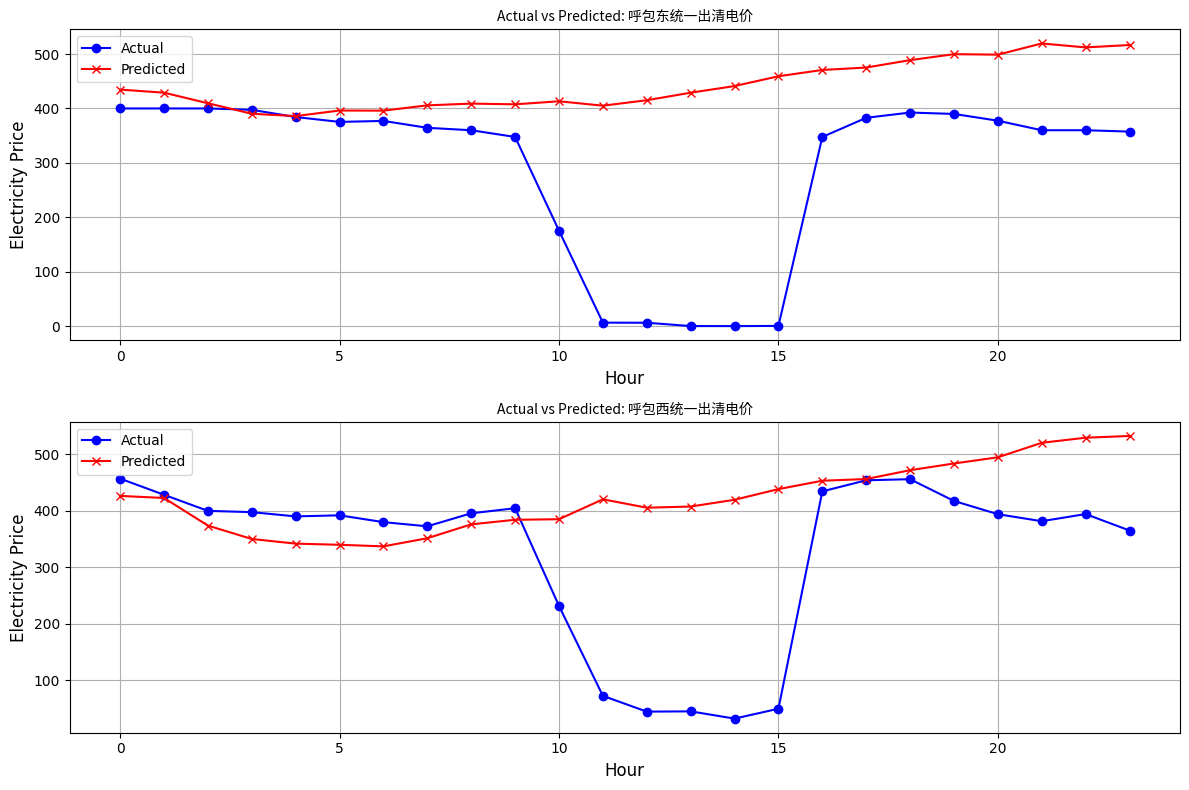

In [8]:
sample_idx = 0
time_steps = np.arange(output_length)  # e.g., 0,1,...,23 for 24 hours

plt.figure(figsize=(12, 8))

# Plot for the first target feature
plt.subplot(2, 1, 1)
plt.plot(time_steps, Y_test_orig[sample_idx, :, 0], label='Actual', marker='o', color='blue')
plt.plot(time_steps, Y_pred_orig[sample_idx, :, 0], label='Predicted', marker='x', color='red')
plt.title(f'Actual vs Predicted: {target_columns[0]}', fontsize=14, fontproperties=font_prop)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Electricity Price', fontsize=12)
plt.legend()
plt.grid(True)

# Plot for the second target feature
plt.subplot(2, 1, 2)
plt.plot(time_steps, Y_test_orig[sample_idx, :, 1], label='Actual', marker='o', color='blue')
plt.plot(time_steps, Y_pred_orig[sample_idx, :, 1], label='Predicted', marker='x', color='red')
plt.title(f'Actual vs Predicted: {target_columns[1]}', fontsize=14, fontproperties=font_prop)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Electricity Price', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()